In [44]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

'1.1.2'

In [45]:
filename = "data/01-04-23.csv"

In [46]:
df = pd.read_csv(filename, names=["rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"], skiprows=1)

In [47]:
df

,rooms,area,rent,street,zip_code,latitude,longitude
0,1,26,8650,Finsensvej,2000,55.681189,12.518624
1,2,38,11800,Finsensvej,2000,55.681189,12.518624
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169
4,1,47,9600,Torvegade,1400,55.671192,12.593326
...,...,...,...,...,...,...,...
1881,3,68,5700,Birkegade,2200,55.690001,12.558017
1882,2,54,6800,Århusgade,2100,55.705868,12.578911
1883,2,66,5260,Vigerslevvej,2500,55.648242,12.492380
1884,3,78,4900,Solnavej,2860,55.743446,12.501736


In [48]:
df.columns

Index(['rooms', 'area', 'rent', 'street', 'zip_code', 'latitude', 'longitude'], dtype='object')

# Data anomalities

In [49]:
# Uniqueness
duplicates = df.duplicated()
duplicates_df = df[duplicates]

In [50]:
# Get number of duplicates
df.duplicated().value_counts()

False    1452
True      434
dtype: int64

In [51]:
# Display the duplicates - Note: They are not necessarily duplicates as street/door numnber is not included.
duplicates_df.sort_values(by=['street', 'area'])

,rooms,area,rent,street,zip_code,latitude,longitude
1464,4,97,14600,Aage Knudsens Strøg,2610,55.688955,12.449246
1599,4,97,14600,Aage Knudsens Strøg,2610,55.688955,12.449246
1677,4,97,14400,Aage Knudsens Strøg,2610,55.688955,12.449246
1057,4,98,14300,Aage Knudsens Strøg,2610,55.688955,12.449246
1357,4,98,14400,Aage Knudsens Strøg,2610,55.688955,12.449246
...,...,...,...,...,...,...,...
908,4,119,15800,Ørestads Boulevard,2300,55.636709,12.582897
1331,4,129,15900,Ørestads Boulevard,2300,55.636709,12.582897
459,1,38,9300,Øresundsvej,2300,55.660626,12.613696
617,1,38,9300,Øresundsvej,2300,55.660626,12.613696


In [52]:
# Get number of different zip codes
df['zip_code'].value_counts()

2300    741
2610    269
2450    221
2700    123
2500     79
       ... 
1254      1
1660      1
1203      1
1738      1
1458      1
Name: zip_code, Length: 81, dtype: int64

In [53]:
# Get number of nan values per columns
for col in df.columns:
    print(col)
    print(df[col].isnull().values.sum())

rooms
0
area
0
rent
0
street
0
zip_code
0
latitude
6
longitude
6


In [54]:
# Dataframe with nans dropped
df2 = df.dropna()

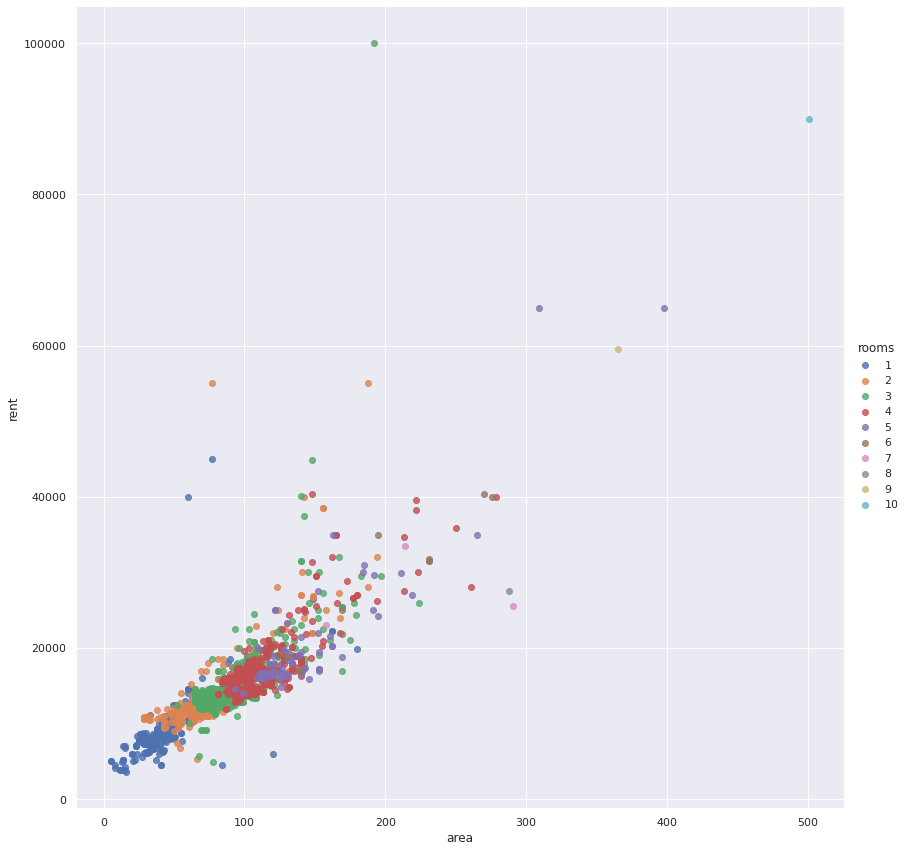

In [55]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

# Data wrangling (normalize)

In [56]:
df2["rent_norm"] = df2["rent"] / df2["area"]

In [57]:
df2

,rooms,area,rent,street,zip_code,latitude,longitude,rent_norm
0,1,26,8650,Finsensvej,2000,55.681189,12.518624,332.692308
1,2,38,11800,Finsensvej,2000,55.681189,12.518624,310.526316
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609,109.560976
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169,109.219512
4,1,47,9600,Torvegade,1400,55.671192,12.593326,204.255319
...,...,...,...,...,...,...,...,...
1881,3,68,5700,Birkegade,2200,55.690001,12.558017,83.823529
1882,2,54,6800,Århusgade,2100,55.705868,12.578911,125.925926
1883,2,66,5260,Vigerslevvej,2500,55.648242,12.492380,79.696970
1884,3,78,4900,Solnavej,2860,55.743446,12.501736,62.820513


In [59]:
# Saving the file with added norm column
df2.to_csv(filename.split(".")[0] + "_norm" + ".csv")

# Geopandas

In [60]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326"))

In [61]:
gdf

,rooms,area,rent,street,zip_code,latitude,longitude,rent_norm,geometry
0,1,26,8650,Finsensvej,2000,55.681189,12.518624,332.692308,POINT (12.51862 55.68119)
1,2,38,11800,Finsensvej,2000,55.681189,12.518624,310.526316,POINT (12.51862 55.68119)
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609,109.560976,POINT (12.53361 55.69510)
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169,109.219512,POINT (12.57317 55.61870)
4,1,47,9600,Torvegade,1400,55.671192,12.593326,204.255319,POINT (12.59333 55.67119)
...,...,...,...,...,...,...,...,...,...
1881,3,68,5700,Birkegade,2200,55.690001,12.558017,83.823529,POINT (12.55802 55.69000)
1882,2,54,6800,Århusgade,2100,55.705868,12.578911,125.925926,POINT (12.57891 55.70587)
1883,2,66,5260,Vigerslevvej,2500,55.648242,12.492380,79.696970,POINT (12.49238 55.64824)
1884,3,78,4900,Solnavej,2860,55.743446,12.501736,62.820513,POINT (12.50174 55.74345)


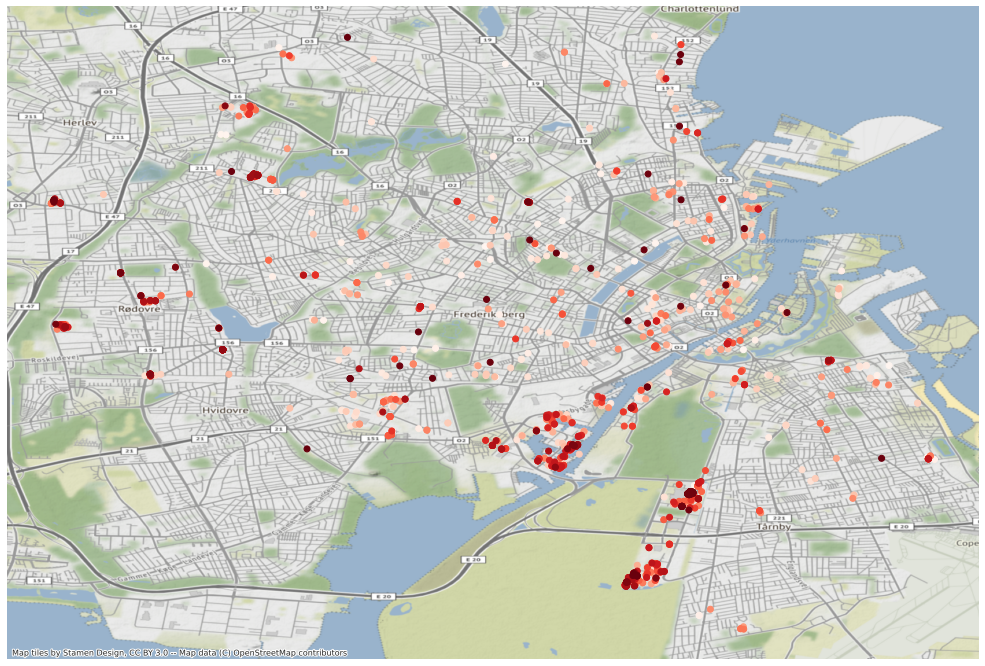

In [62]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

# Postal Code data

Note: The data is found here: https://github.com/mortenscheel/postnumre-geojson-clipped

In [63]:
postal_codes = gpd.read_file("data/postnumre-clipped-simplified.geojson")

In [64]:
postal_codes

,href,nr,navn,stormodtageradresser,kommuner,ændret,geo_ændret,geo_version,dagi_id,geometry
0,https://dawa.aws.dk/postnumre/1050,1050,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,191050,"POLYGON ((12.58424 55.67914, 12.58435 55.67996..."
1,https://dawa.aws.dk/postnumre/1051,1051,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2016-11-10T21:36:32.077999+00:00,2,191051,"MULTIPOLYGON (((12.58775 55.68087, 12.58945 55..."
2,https://dawa.aws.dk/postnumre/1052,1052,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,191052,"MULTIPOLYGON (((12.58845 55.67919, 12.58900 55..."
3,https://dawa.aws.dk/postnumre/1053,1053,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,191053,"POLYGON ((12.59081 55.67853, 12.59128 55.67825..."
4,https://dawa.aws.dk/postnumre/1054,1054,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,191054,"MULTIPOLYGON (((12.58775 55.67896, 12.58845 55..."
...,...,...,...,...,...,...,...,...,...,...
1084,https://dawa.aws.dk/postnumre/9940,9940,Læsø,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,199940,"MULTIPOLYGON (((10.87004 57.25799, 10.87327 57..."
1085,https://dawa.aws.dk/postnumre/9970,9970,Strandby,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,199970,"POLYGON ((10.43530 57.49393, 10.45462 57.49448..."
1086,https://dawa.aws.dk/postnumre/9981,9981,Jerup,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,199981,"POLYGON ((10.34774 57.52611, 10.35645 57.54168..."
1087,https://dawa.aws.dk/postnumre/9982,9982,Ålbæk,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2014-11-04T16:01:00.879000+00:00,1,199982,"POLYGON ((10.27069 57.61845, 10.32013 57.63489..."


In [65]:
postal_codes.crs, gdf.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

## Getting only Postal Codes that the rental points are in

Later, we might want to limit the Postal Codes by Copenhagen instead, if we for some reason want to also show postal codes in Copenhagen that we don't have data points of. We might also consider aggregating some postal codes that a split up too granuarily.

In [66]:
# Joining postal and points
postal_codes['nr']=postal_codes['nr'].astype(int)
gdf2 = gdf.merge(postal_codes, left_on='zip_code', right_on="nr", how="left")

In [67]:
gdf2

,rooms,area,rent,street,zip_code,latitude,longitude,rent_norm,geometry_x,href,nr,navn,stormodtageradresser,kommuner,ændret,geo_ændret,geo_version,dagi_id,geometry_y
0,1,26,8650,Finsensvej,2000,55.681189,12.518624,332.692308,POINT (12.51862 55.68119),https://dawa.aws.dk/postnumre/2000,2000,Frederiksberg,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-05-18T21:15:28.822001+00:00,2018-05-18T21:15:28.822001+00:00,5,192000,"POLYGON ((12.49132 55.67908, 12.50397 55.68826..."
1,2,38,11800,Finsensvej,2000,55.681189,12.518624,310.526316,POINT (12.51862 55.68119),https://dawa.aws.dk/postnumre/2000,2000,Frederiksberg,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-05-18T21:15:28.822001+00:00,2018-05-18T21:15:28.822001+00:00,5,192000,"POLYGON ((12.49132 55.67908, 12.50397 55.68826..."
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609,109.560976,POINT (12.53361 55.69510),https://dawa.aws.dk/postnumre/2000,2000,Frederiksberg,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-05-18T21:15:28.822001+00:00,2018-05-18T21:15:28.822001+00:00,5,192000,"POLYGON ((12.49132 55.67908, 12.50397 55.68826..."
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169,109.219512,POINT (12.57317 55.61870),https://dawa.aws.dk/postnumre/2300,2300,København S,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2019-03-14T22:13:12.119000+00:00,2019-03-14T22:13:12.119000+00:00,8,192300,"POLYGON ((12.51527 55.61549, 12.53420 55.63048..."
4,1,47,9600,Torvegade,1400,55.671192,12.593326,204.255319,POINT (12.59333 55.67119),https://dawa.aws.dk/postnumre/1400,1400,København K,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2019-09-13T21:13:15.692000+00:00,2019-09-13T21:13:15.692000+00:00,5,191400,"MULTIPOLYGON (((12.58675 55.67485, 12.58682 55..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,3,68,5700,Birkegade,2200,55.690001,12.558017,83.823529,POINT (12.55802 55.69000),https://dawa.aws.dk/postnumre/2200,2200,København N,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2019-08-09T21:11:20.875000+00:00,2019-08-09T21:11:20.875000+00:00,6,192200,"POLYGON ((12.54453 55.70786, 12.55884 55.70289..."
1876,2,54,6800,Århusgade,2100,55.705868,12.578911,125.925926,POINT (12.57891 55.70587),https://dawa.aws.dk/postnumre/2100,2100,København Ø,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-09-02T21:12:21.101000+00:00,2018-09-02T21:12:21.101000+00:00,4,192100,"POLYGON ((12.54611 55.72270, 12.55441 55.72293..."
1877,2,66,5260,Vigerslevvej,2500,55.648242,12.492380,79.696970,POINT (12.49238 55.64824),https://dawa.aws.dk/postnumre/2500,2500,Valby,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2019-01-11T22:10:34.105999+00:00,2019-01-11T22:10:34.105999+00:00,5,192500,"POLYGON ((12.47732 55.65937, 12.47732 55.65937..."
1878,3,78,4900,Solnavej,2860,55.743446,12.501736,62.820513,POINT (12.50174 55.74345),https://dawa.aws.dk/postnumre/2860,2860,Søborg,None,"[ { ""href"": ""https:\/\/dawa.aws.dk\/kommuner\/...",2018-04-30T15:23:13.528000+00:00,2015-09-01T21:42:42.765999+00:00,2,192860,"MULTIPOLYGON (((12.44573 55.74819, 12.44573 55..."


In [68]:
# Select only postal code geometries that have a data point in them
postal_codes = postal_codes[postal_codes["nr"].isin(set(gdf2["zip_code"]))]

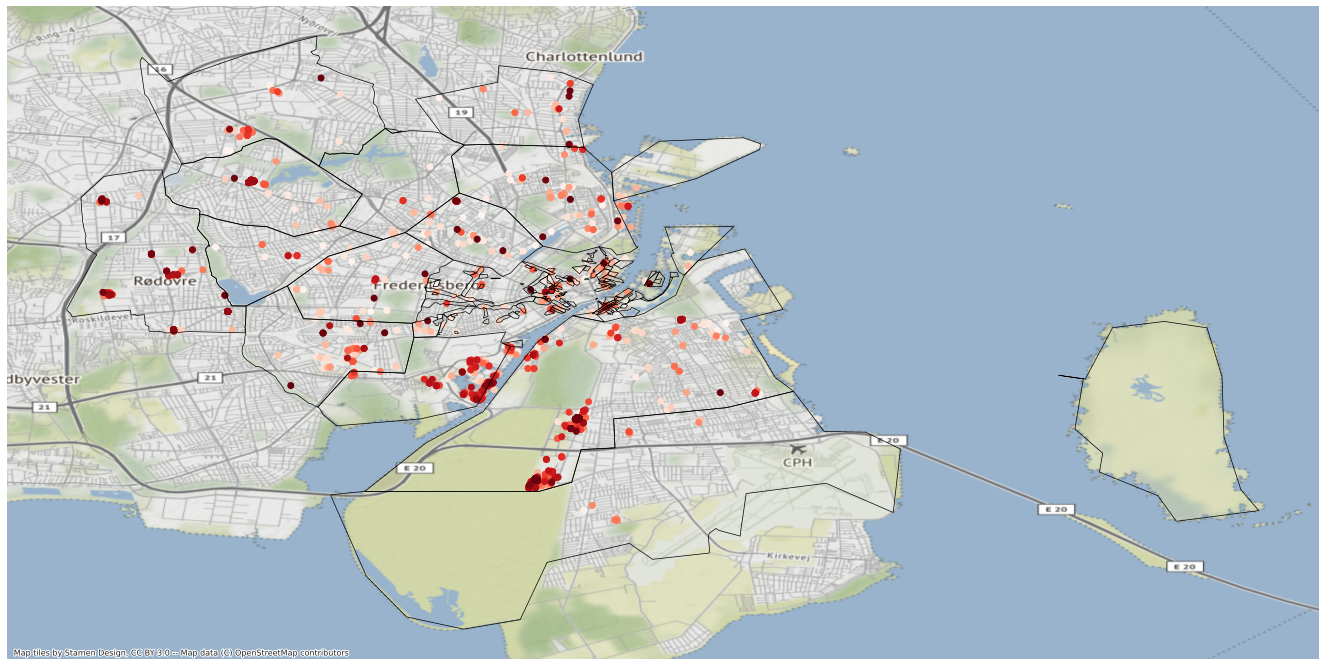

In [69]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax2 = postal_codes.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')